In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Loading the data

In [25]:
data = pd.read_csv("digit-recognizer/train.csv")

In [26]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T # flip it so that each column is an example, not each row
X_dev = data_dev[1:n]
Y_dev = data_dev[0]

data_train = data[1000:m].T
X_train = data_train[1:n]
Y_train = data_train[0]

X_train = X_train / 255
X_dev = X_dev / 255

_, m_train = X_train.shape

In [28]:
(m, n)

(42000, 785)

In [29]:
data

array([[2, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], shape=(42000, 785))

In [30]:
X_dev

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 1000))

In [31]:
Y_train

array([5, 3, 6, ..., 5, 0, 1], shape=(41000,))

In [32]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(784, 41000))

# Defining parameters

In [33]:
def init_params():
    W1 = np.random.randn(10, 784) * np.sqrt(2.0 / 784)  # He initialization for ReLU
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * np.sqrt(2.0 / 10)    # He initialization
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_prime(x):
    return x > 0

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_propagation(W1, b1, W2, b2, X):
    Z1 = W1 @ X + b1
    A1 = ReLU(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot_encode(Y):
    one_hot = np.zeros((Y.size, Y.max() + 1))
    one_hot[np.arange(Y.size), Y] = 1
    one_hot = one_hot.T
    return one_hot

def back_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot = one_hot_encode(Y)

    dZ2 = A2 - one_hot
    dW2 = (1/m) * (dZ2 @ A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = (W2.T @ dZ2) * ReLU_prime(Z1)
    dW1 = (1/m) * (dZ1 @ X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

`np.random.rand(10, 784)` returns a 2D NumPy array of shape (10, 784).
Entries are independent Uniform(0, 1) real numbers (all non-negative).

The only accident that might happen is over- or under-flow in the exponentials if we use softmax = exp(x)/sum(exp(x)). Overflow of a single or underflow of all elements of x will render the output more or less useless.

But it is easy to guard against that by using the identity softmax(x) = softmax(x + c) which holds for any scalar c: Subtracting max(x) from x leaves a vector that has only non-positive entries, ruling out overflow and at least one element that is zero ruling out a vanishing denominator (underflow in some but not all entries is harmless).

In [34]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def clip_gradients(dW1, db1, dW2, db2, max_norm=1.0):
    grad_norm = np.sqrt(np.sum(dW1**2) + np.sum(db1**2) + 
                       np.sum(dW2**2) + np.sum(db2**2))
    
    if grad_norm > max_norm:
        scale = max_norm / grad_norm
        dW1 = dW1 * scale
        db1 = db1 * scale
        dW2 = dW2 * scale
        db2 = db2 * scale
    
    return dW1, db1, dW2, db2

def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_propagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        dW1, db1, dW2, db2 = clip_gradients(dW1, db1, dW2, db2, max_norm=1.0)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if (i+1) % 50 == 0:
            acc  = get_accuracy(get_predictions(A2), Y)
            print(f"epoch {i+1:4d} | acc {acc:.3f}")
            
    return W1, b1, W2, b2

In [12]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.05)

/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:19: RuntimeWarning: divide by zero encountered in matmul
  Z1 = W1 @ X + b1
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:19: RuntimeWarning: overflow encountered in matmul
  Z1 = W1 @ X + b1
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:19: RuntimeWarning: invalid value encountered in matmul
  Z1 = W1 @ X + b1
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:21: RuntimeWarning: divide by zero encountered in matmul
  Z2 = W2 @ A1 + b2
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:21: RuntimeWarning: overflow encountered in matmul
  Z2 = W2 @ A1 + b2
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:21: RuntimeWarning: invalid value encountered in matmul
  Z2 = W2 @ A1 + b2
/var/folders/_1/32hfx73n42q_grncmqsc8ph80000gn/T/ipykernel_97125/3131647211.py:36

[4 0 5 ... 4 3 5] [4 2 3 ... 4 2 3]
epoch   50 | acc 0.368
[4 0 3 ... 4 3 3] [4 2 3 ... 4 2 3]
epoch  100 | acc 0.612
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  150 | acc 0.793
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  200 | acc 0.831
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  250 | acc 0.852
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  300 | acc 0.866
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  350 | acc 0.874
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  400 | acc 0.880
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  450 | acc 0.885
[4 2 3 ... 4 2 3] [4 2 3 ... 4 2 3]
epoch  500 | acc 0.888


# Now let's get rid of these warnings

In [19]:
import numpy as np
import warnings

def safe_matmul(A, B):
    return np.einsum('ij,jk->ik', A, B)

def preprocess_sparse_data(X, min_variance=1e-8):
    noise_scale = 1e-8
    X_processed = X.copy()
    
    zero_mask = (X_processed == 0.0)
    X_processed[zero_mask] += np.random.normal(0, noise_scale, size=np.sum(zero_mask))
    
    feature_vars = np.var(X_processed, axis=1)
    low_var_mask = feature_vars < min_variance
    
    if np.any(low_var_mask):
        print(f"Adding noise to {np.sum(low_var_mask)} low-variance features")
        X_processed[low_var_mask] += np.random.normal(0, noise_scale, 
                                                     size=(np.sum(low_var_mask), X_processed.shape[1]))
    
    return X_processed

def init_params():
    W1 = np.random.randn(10, 784) * np.sqrt(2.0 / 784)
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * np.sqrt(2.0 / 10)
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_prime(x):
    return x > 0

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_propagation_safe(W1, b1, W2, b2, X):
    Z1 = safe_matmul(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = safe_matmul(W2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot_encode(Y):
    one_hot = np.zeros((Y.size, Y.max() + 1))
    one_hot[np.arange(Y.size), Y] = 1
    return one_hot.T

def back_propagation_safe(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot = one_hot_encode(Y)
    
    dZ2 = A2 - one_hot
    dW2 = (1/m) * safe_matmul(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = safe_matmul(W2.T, dZ2) * ReLU_prime(Z1)
    dW1 = (1/m) * safe_matmul(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def clip_gradients(dW1, db1, dW2, db2, max_norm=1.0):
    grad_norm = np.sqrt(np.sum(dW1**2) + np.sum(db1**2) + 
                       np.sum(dW2**2) + np.sum(db2**2))
    
    if grad_norm > max_norm:
        scale = max_norm / grad_norm
        dW1 = dW1 * scale
        db1 = db1 * scale
        dW2 = dW2 * scale
        db2 = db2 * scale
    
    return dW1, db1, dW2, db2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent_safe(X, Y, iterations, alpha):
    X_processed = preprocess_sparse_data(X)
    
    W1, b1, W2, b2 = init_params()
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation_safe(W1, b1, W2, b2, X_processed)
        dW1, db1, dW2, db2 = back_propagation_safe(Z1, A1, Z2, A2, W1, W2, X_processed, Y)
        dW1, db1, dW2, db2 = clip_gradients(dW1, db1, dW2, db2, max_norm=1.0)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if (i+1) % 50 == 0:
            acc = get_accuracy(get_predictions(A2), Y)
            print(f"epoch {i+1:4d} | acc {acc:.3f}")
    
    return W1, b1, W2, b2

In [20]:
W1, b1, W2, b2 = gradient_descent_safe(X_train, Y_train, 500, 0.05)

Adding noise to 77 low-variance features
epoch   50 | acc 0.599
epoch  100 | acc 0.748
epoch  150 | acc 0.805
epoch  200 | acc 0.840
epoch  250 | acc 0.857
epoch  300 | acc 0.868
epoch  350 | acc 0.875
epoch  400 | acc 0.880
epoch  450 | acc 0.885
epoch  500 | acc 0.888


# Testing the model

In [37]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propagation_safe(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [38]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[2 7 9 0 0 5 6 2 5 5 5 5 7 3 1 0 2 5 3 3 0 5 5 0 1 7 4 7 7 0 6 3 9 1 6 6 1
 0 5 3 4 2 4 3 4 8 7 7 8 4 2 3 3 9 4 1 4 6 9 5 5 7 9 0 0 5 9 4 1 9 5 4 1 0
 5 9 1 3 0 4 8 8 5 1 4 2 6 1 2 9 0 4 5 8 1 3 8 5 5 4 4 6 7 1 7 4 2 6 4 4 4
 0 1 7 4 5 7 5 1 0 0 7 9 1 6 0 3 6 3 8 1 9 1 8 0 4 4 2 1 2 1 7 6 2 4 0 0 3
 0 3 0 8 7 2 9 8 6 3 2 3 0 1 7 0 2 5 7 7 1 7 0 8 8 6 6 4 0 8 0 3 7 2 1 2 6
 9 4 5 2 2 6 8 6 9 0 4 6 1 6 1 2 2 7 6 0 7 1 1 7 8 1 0 9 9 6 9 7 4 6 8 3 9
 2 9 6 2 9 4 0 1 9 4 1 3 3 0 2 4 1 3 5 7 2 4 3 4 0 3 0 8 8 3 8 9 0 6 9 2 4
 0 5 5 9 2 5 0 4 6 0 4 1 2 1 2 7 9 0 7 7 6 9 4 5 4 7 2 1 1 3 9 4 6 7 9 8 3
 9 3 0 5 8 0 1 1 3 2 4 0 4 9 0 3 4 2 4 1 1 8 8 9 2 4 4 2 7 0 9 2 7 4 1 2 1
 2 7 6 1 3 5 8 3 0 6 7 2 0 4 5 0 9 6 4 3 1 5 0 5 8 4 2 7 4 2 4 2 8 9 2 1 1
 4 0 5 4 9 6 5 7 6 7 3 3 8 2 4 9 3 5 0 7 0 7 7 6 7 3 4 7 0 1 7 4 5 5 6 1 8
 6 6 6 0 1 1 0 8 0 2 8 4 2 7 1 7 0 7 4 9 9 2 2 1 4 1 8 9 4 0 9 2 6 6 1 9 2
 4 0 2 2 0 9 9 8 1 3 2 6 1 9 2 3 2 2 2 6 5 1 4 5 6 3 5 1 0 4 6 5 9 7 7 1 2
 0 9 4 8 4 6 3 6 7 7 9 9 

np.float64(0.887)

Prediction:  [5]
Label:  5


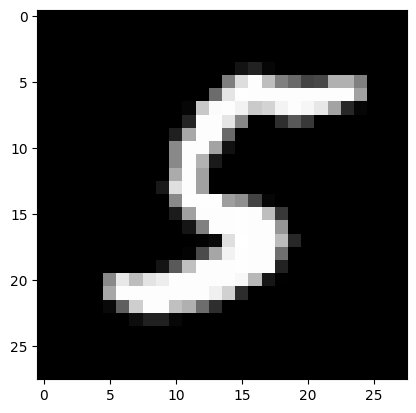

In [39]:
test_prediction(0, W1, b1, W2, b2)

In [40]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[2 7 9 0 0 5 6 2 5 5 5 5 7 3 1 0 2 5 3 3 0 5 5 0 1 7 4 7 7 0 6 3 9 1 6 6 1
 0 5 3 4 2 4 3 4 8 7 7 8 4 2 3 3 9 4 1 4 6 9 5 5 7 9 0 0 5 9 4 1 9 5 4 1 0
 5 9 1 3 0 4 8 8 5 1 4 2 6 1 2 9 0 4 5 8 1 3 8 5 5 4 4 6 7 1 7 4 2 6 4 4 4
 0 1 7 4 5 7 5 1 0 0 7 9 1 6 0 3 6 3 8 1 9 1 8 0 4 4 2 1 2 1 7 6 2 4 0 0 3
 0 3 0 8 7 2 9 8 6 3 2 3 0 1 7 0 2 5 7 7 1 7 0 8 8 6 6 4 0 8 0 3 7 2 1 2 6
 9 4 5 2 2 6 8 6 9 0 4 6 1 6 1 2 2 7 6 0 7 1 1 7 8 1 0 9 9 6 9 7 4 6 8 3 9
 2 9 6 2 9 4 0 1 9 4 1 3 3 0 2 4 1 3 5 7 2 4 3 4 0 3 0 8 8 3 8 9 0 6 9 2 4
 0 5 5 9 2 5 0 4 6 0 4 1 2 1 2 7 9 0 7 7 6 9 4 5 4 7 2 1 1 3 9 4 6 7 9 8 3
 9 3 0 5 8 0 1 1 3 2 4 0 4 9 0 3 4 2 4 1 1 8 8 9 2 4 4 2 7 0 9 2 7 4 1 2 1
 2 7 6 1 3 5 8 3 0 6 7 2 0 4 5 0 9 6 4 3 1 5 0 5 8 4 2 7 4 2 4 2 8 9 2 1 1
 4 0 5 4 9 6 5 7 6 7 3 3 8 2 4 9 3 5 0 7 0 7 7 6 7 3 4 7 0 1 7 4 5 5 6 1 8
 6 6 6 0 1 1 0 8 0 2 8 4 2 7 1 7 0 7 4 9 9 2 2 1 4 1 8 9 4 0 9 2 6 6 1 9 2
 4 0 2 2 0 9 9 8 1 3 2 6 1 9 2 3 2 2 2 6 5 1 4 5 6 3 5 1 0 4 6 5 9 7 7 1 2
 0 9 4 8 4 6 3 6 7 7 9 9 

np.float64(0.887)

This is just slightly lower than our training accuracy

# Trying two layers with 16 activations

We'll reintroduce some functions here so that this part is runnable separately

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def init_params_2hidden():
    # First hidden layer: 784 -> 16
    W1 = np.random.randn(16, 784) * np.sqrt(2.0 / 784)
    b1 = np.zeros((16, 1))
    
    # Second hidden layer: 16 -> 16  
    W2 = np.random.randn(16, 16) * np.sqrt(2.0 / 16)
    b2 = np.zeros((16, 1))
    
    # Output layer: 16 -> 10
    W3 = np.random.randn(10, 16) * np.sqrt(2.0 / 16)
    b3 = np.zeros((10, 1))
    
    return W1, b1, W2, b2, W3, b3

In [43]:
def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_prime(x):
    return x > 0

def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [44]:
def forward_propagation_2hidden(W1, b1, W2, b2, W3, b3, X):
    # First hidden layer
    Z1 = safe_matmul(W1, X) + b1
    A1 = ReLU(Z1)
    
    # Second hidden layer
    Z2 = safe_matmul(W2, A1) + b2
    A2 = ReLU(Z2)
    
    # Output layer
    Z3 = safe_matmul(W3, A2) + b3
    A3 = softmax(Z3)
    
    return Z1, A1, Z2, A2, Z3, A3

In [45]:
def back_propagation_2hidden(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    m = Y.size
    one_hot = one_hot_encode(Y)
    
    # Output layer gradients
    dZ3 = A3 - one_hot
    dW3 = (1/m) * safe_matmul(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)
    
    # Second hidden layer gradients
    dZ2 = safe_matmul(W3.T, dZ3) * ReLU_prime(Z2)
    dW2 = (1/m) * safe_matmul(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # First hidden layer gradients
    dZ1 = safe_matmul(W2.T, dZ2) * ReLU_prime(Z1)
    dW1 = (1/m) * safe_matmul(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3

In [46]:
def update_params_2hidden(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    
    return W1, b1, W2, b2, W3, b3

In [47]:
def clip_gradients_2hidden(dW1, db1, dW2, db2, dW3, db3, max_norm=1.0):
    grad_norm = np.sqrt(np.sum(dW1**2) + np.sum(db1**2) + 
                       np.sum(dW2**2) + np.sum(db2**2) +
                       np.sum(dW3**2) + np.sum(db3**2))
    
    if grad_norm > max_norm:
        scale = max_norm / grad_norm
        dW1 = dW1 * scale
        db1 = db1 * scale
        dW2 = dW2 * scale
        db2 = db2 * scale
        dW3 = dW3 * scale
        db3 = db3 * scale
    
    return dW1, db1, dW2, db2, dW3, db3

In [48]:
def get_predictions_2hidden(A3):
    return np.argmax(A3, 0)

def get_accuracy_2hidden(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [52]:
def gradient_descent_2hidden(X, Y, iterations, alpha):
    print("Training Two Hidden Layers Network")
    print("Architecture: 784 -> 16 -> 16 -> 10")
    
    total_params = (784*16 + 16) + (16*16 + 16) + (16*10 + 10)
    print(f"Total parameters: {total_params}")
    
    X_processed = preprocess_sparse_data(X)
    
    W1, b1, W2, b2, W3, b3 = init_params_2hidden()
    
    for i in range(iterations):
        # Forward pass
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation_2hidden(W1, b1, W2, b2, W3, b3, X_processed)
        
        # Backward pass
        dW1, db1, dW2, db2, dW3, db3 = back_propagation_2hidden(Z1, A1, Z2, A2, Z3, A3, 
                                                                W1, W2, W3, X_processed, Y)
        
        # Gradient clipping
        dW1, db1, dW2, db2, dW3, db3 = clip_gradients_2hidden(dW1, db1, dW2, db2, dW3, db3, 
                                                              max_norm=1.0)
        
        # Update parameters
        W1, b1, W2, b2, W3, b3 = update_params_2hidden(W1, b1, W2, b2, W3, b3, 
                                                       dW1, db1, dW2, db2, dW3, db3, alpha)
        
        # Print progress
        if (i+1) % 50 == 0:
            acc = get_accuracy_2hidden(get_predictions_2hidden(A3), Y)
            print(f"epoch {i+1:4d} | acc {acc:.3f}")
    
    return W1, b1, W2, b2, W3, b3

In [50]:
def make_predictions_2hidden(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation_2hidden(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions_2hidden(A3)
    return predictions

def test_prediction_2hidden(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index, None]
    prediction = make_predictions_2hidden(X_train[:, index, None], W1, b1, W2, b2, W3, b3)
    label = Y_train[index]
    
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

# Training

In [53]:
W1_2h, b1_2h, W2_2h, b2_2h, W3_2h, b3_2h = gradient_descent_2hidden(X_train, Y_train, 500, 0.05)

Training Two Hidden Layers Network
Architecture: 784 -> 16 -> 16 -> 10
Total parameters: 13002
Adding noise to 77 low-variance features
epoch   50 | acc 0.469
epoch  100 | acc 0.725
epoch  150 | acc 0.808
epoch  200 | acc 0.841
epoch  250 | acc 0.860
epoch  300 | acc 0.873
epoch  350 | acc 0.882
epoch  400 | acc 0.888
epoch  450 | acc 0.893
epoch  500 | acc 0.898


# Testing on dev set

In [54]:
dev_predictions_2h = make_predictions_2hidden(X_dev, W1_2h, b1_2h, W2_2h, b2_2h, W3_2h, b3_2h)
dev_accuracy_2h = get_accuracy_2hidden(dev_predictions_2h, Y_dev)

print(f"Two hidden layers network dev acc: {dev_accuracy_2h:.3f} ({dev_accuracy_2h*100:.1f}%)")

Two hidden layers network dev acc: 0.897 (89.7%)


In [55]:
dev_predictions_1h = make_predictions(X_dev, W1, b1, W2, b2)
dev_accuracy_1h = get_accuracy(dev_predictions_1h, Y_dev)

print(f"Comparison:")
print(f"Single Hidden Layer (10): {dev_accuracy_1h:.3f} ({dev_accuracy_1h*100:.1f}%)")
print(f"Two Hidden Layers (16-16): {dev_accuracy_2h:.3f} ({dev_accuracy_2h*100:.1f}%)")

improvement = (dev_accuracy_2h - dev_accuracy_1h) * 100
print(f"Improvement: {improvement:+.1f} percentage points")


[2 7 9 0 0 5 6 2 5 5 5 5 7 3 1 0 2 5 3 3 0 5 5 0 1 7 4 7 7 0 6 3 9 1 6 6 1
 0 5 3 4 2 4 3 4 8 7 7 8 4 2 3 3 9 4 1 4 6 9 5 5 7 9 0 0 5 9 4 1 9 5 4 1 0
 5 9 1 3 0 4 8 8 5 1 4 2 6 1 2 9 0 4 5 8 1 3 8 5 5 4 4 6 7 1 7 4 2 6 4 4 4
 0 1 7 4 5 7 5 1 0 0 7 9 1 6 0 3 6 3 8 1 9 1 8 0 4 4 2 1 2 1 7 6 2 4 0 0 3
 0 3 0 8 7 2 9 8 6 3 2 3 0 1 7 0 2 5 7 7 1 7 0 8 8 6 6 4 0 8 0 3 7 2 1 2 6
 9 4 5 2 2 6 8 6 9 0 4 6 1 6 1 2 2 7 6 0 7 1 1 7 8 1 0 9 9 6 9 7 4 6 8 3 9
 2 9 6 2 9 4 0 1 9 4 1 3 3 0 2 4 1 3 5 7 2 4 3 4 0 3 0 8 8 3 8 9 0 6 9 2 4
 0 5 5 9 2 5 0 4 6 0 4 1 2 1 2 7 9 0 7 7 6 9 4 5 4 7 2 1 1 3 9 4 6 7 9 8 3
 9 3 0 5 8 0 1 1 3 2 4 0 4 9 0 3 4 2 4 1 1 8 8 9 2 4 4 2 7 0 9 2 7 4 1 2 1
 2 7 6 1 3 5 8 3 0 6 7 2 0 4 5 0 9 6 4 3 1 5 0 5 8 4 2 7 4 2 4 2 8 9 2 1 1
 4 0 5 4 9 6 5 7 6 7 3 3 8 2 4 9 3 5 0 7 0 7 7 6 7 3 4 7 0 1 7 4 5 5 6 1 8
 6 6 6 0 1 1 0 8 0 2 8 4 2 7 1 7 0 7 4 9 9 2 2 1 4 1 8 9 4 0 9 2 6 6 1 9 2
 4 0 2 2 0 9 9 8 1 3 2 6 1 9 2 3 2 2 2 6 5 1 4 5 6 3 5 1 0 4 6 5 9 7 7 1 2
 0 9 4 8 4 6 3 6 7 7 9 9 

Prediction:  [8]
Label:  8


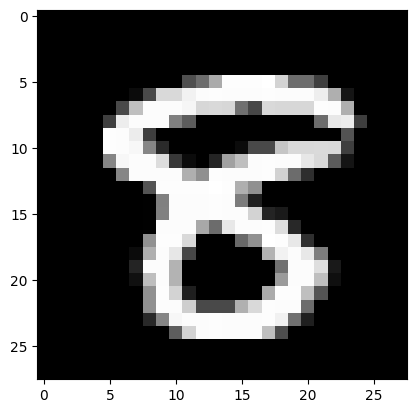

In [60]:
test_prediction_2hidden(20, W1_2h, b1_2h, W2_2h, b2_2h, W3_2h, b3_2h)

# Wrapping up

We built a NumPy-only digit recognizer, starting simple and then adding a second hidden layer. The biggest early failure was that the model was essentially randomly guessing with accuracy of 11%. That was primarity due to a wrong softmax (computed across the whole matrix instead of per example), risky weight/bias initialization, incorrect bias-gradient shapes, and inconsistent normalization between train and dev. We then implemented the following fixes: a numerically stable, per-example softmax; *He* initialization with zero biases; proper `axis`/`keepdims` in gradient sums; and identical preprocessing for train/dev.

Once learning started, training threw some numerical warnings caused by MNIST’s sparse pixels and some zero-variance features. We stabilized this by 

(1) switching to a “safe” matmul path (using `einsum`/`tensordot`), 

(2) adding tiny noise to exact zeros, and 

(3) clipping gradient norms.

With those fixes in place, both the single-layer and the two-layer networks trained cleanly. The deeper model performed slightly better.